In [1]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [2]:
import xgboost as xgb
import numpy as np

In [3]:

from imblearn.over_sampling import SMOTE

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
%matplotlib inline

In [5]:
#importing the data
data =pd.read_csv("D:/Hackethon/AppointMentNoShow/data.csv",na_values=[" ",np.nan,"NA"])
data.head()
data = data.drop("AppointmentID",1)

#lets convert the time fiels to time format
data.ScheduledDay = pd.to_datetime(data.ScheduledDay)
data.AppointmentDay = pd.to_datetime(data.AppointmentDay)
from datetime import datetime
data["daysToappointment"]= (data.AppointmentDay-data.ScheduledDay).dt.days +1
#Getting hour of booking
def houroftheday(timestamp):
#     converting to string so that the hours can be picked using the character index
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute =int(timestamp[14:16])
    seconds = int(timestamp[17:])
    Hour = round(hour +(minute/60) +(seconds/3600))
    return Hour

data["hourOfBooking"] = data.ScheduledDay.apply(houroftheday)


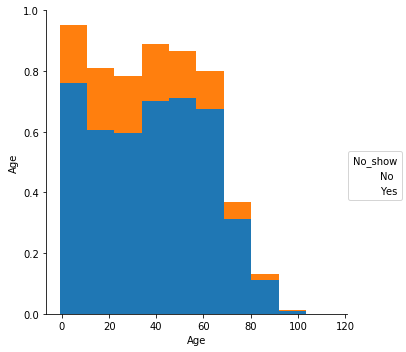

In [8]:
sns.pairplot(data[["Age","No_show"]],hue="No_show",size=5)

In [12]:
pd.crosstab(columns=data.Neighbourhood,index=data.No_show,margins=True)

Neighbourhood,AEROPORTO,ANDORINHAS,ANTÔNIO HONÓRIO,ARIOVALDO FAVALESSA,BARRO VERMELHO,BELA VISTA,BENTO FERREIRA,BOA VISTA,BONFIM,CARATOÍRA,...,SEGURANÇA DO LAR,SOLON BORGES,SÃO BENEDITO,SÃO CRISTÓVÃO,SÃO JOSÉ,SÃO PEDRO,TABUAZEIRO,UNIVERSITÁRIO,VILA RUBIM,All
No_show,,,,,,,,,,,,,,,,,,,,,
No,7,1741,221,220,332,1523,665,254,2223,1974,...,117,400,1152,1473,1549,1933,2559,120,710,88208
Yes,1,521,50,62,91,384,193,58,550,591,...,28,69,287,363,428,515,573,32,141,22319
All,8,2262,271,282,423,1907,858,312,2773,2565,...,145,469,1439,1836,1977,2448,3132,152,851,110527


In [5]:
#importing the data
data =pd.read_csv("D:/Hackethon/AppointMentNoShow/data.csv",na_values=[" ",np.nan,"NA"])
data.head()
data = data.drop("AppointmentID",1)

#lets convert the time fiels to time format
data.ScheduledDay = pd.to_datetime(data.ScheduledDay)
data.AppointmentDay = pd.to_datetime(data.AppointmentDay)
from datetime import datetime
data["daysToappointment"]= (data.AppointmentDay-data.ScheduledDay).dt.days +1
#Getting hour of booking
def houroftheday(timestamp):
#     converting to string so that the hours can be picked using the character index
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute =int(timestamp[14:16])
    seconds = int(timestamp[17:])
    Hour = round(hour +(minute/60) +(seconds/3600))
    return Hour

data["hourOfBooking"] = data.ScheduledDay.apply(houroftheday)

#there are very few people above 100 and  below 0
data["falseAge"] = 1
data.loc[(data.Age>=0 ) & (data.Age<=100),"falseAge"]=0

data["AgeCategory"] = pd.cut(data["Age"],bins =[-2,18,37,55,116],labels=["child","young","midage","elder"])

#We see a few values are negative, removing them
data = data[data.daysToappointment>=0]


data["distantAppointment"] = 1
data.loc[(data.daysToappointment<=50),"distantAppointment"]=0
data["daystoAppointmentcat"] =pd.cut(data.daysToappointment,bins=[-1,2,4,15,50,180],labels=["urgent","very near","moderate","distant","far away"])
Y = data.No_show
data =data.drop("No_show",1)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score
from sklearn.preprocessing import OneHotEncoder
from numpy import column_stack

data =data.drop(["PatientId","Age","Neighbourhood","daysToappointment","AppointmentDay","ScheduledDay"],1)

data =data.values

data =data.astype(str)
Columns =[]
labelEncoder =LabelEncoder()
for i in range(data.shape[1]):
    feature = labelEncoder.fit_transform(data[:,i])
    feature = feature.reshape(data.shape[0],1)
    oneHotEncoder = OneHotEncoder(sparse=False)
    Feature_encoded = oneHotEncoder.fit_transform(feature)
    Columns.append(Feature_encoded)
X_Encoded = column_stack(Columns)

TrainS = X_Encoded[:70000,:]
TestS  =X_Encoded[70000:,:]

Y_New = Y[:70000]

Y_Trans = labelEncoder.fit_transform(Y_New)
XTrain,XTest,YTrain,YTest = train_test_split(TrainS,Y_Trans,test_size = 0.2,random_state = 7)

model = XGBClassifier()
model.fit(XTrain,YTrain)
print(model)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [14]:
predcited = model.predict(XTest)
predctions  =[round(value) for value in predcited]
accuracy = (accuracy_score(YTest,predctions))
print("Accuracy : %.2f%%"%(accuracy*100))


Accuracy : 79.01%


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
rfmodel = RandomForestClassifier()
rfmodel.fit(XTrain,YTrain)

predcited = rfmodel.predict(XTest)
predctions  =[round(value) for value in predcited]
accuracy = (accuracy_score(YTest,predctions))
print("Accuracy : %.2f%%"%(accuracy*100))           

Accuracy : 77.71%


In [33]:
from sklearn.metrics import confusion_matrix
Tp,FN,FP,TN =confusion_matrix(YTest,predctions).ravel()
print (confusion_matrix(YTest,predctions))
print (Tp,FN,FP,TN )
from sklearn.metrics import classification_report
print(classification_report(YTest,predctions))


[[10647   415]
 [ 2706   232]]
10647 415 2706 232
             precision    recall  f1-score   support

          0       0.80      0.96      0.87     11062
          1       0.36      0.08      0.13      2938

avg / total       0.71      0.78      0.72     14000



In [16]:
predcited = model.predict(XTrain)
predctions  =[round(value) for value in predcited]
confusion_matrix(YTrain,predctions)

array([[44131,    26],
       [11788,    55]], dtype=int64)

In [20]:
Y_Trans = labelEncoder.fit_transform(Y[70000:])
y_pred =model.predict(TestS)


In [22]:
accuracy_score(Y_Trans,y_pred)

0.8142737278515374

In [23]:
confusion_matrix(Y_Trans,y_pred)

array([[32975,    14],
       [ 7512,    21]], dtype=int64)

In [24]:
pd.crosstab(Y_Trans,y_pred,margins=True)

col_0,0,1,All
row_0,,,
0,32975,14,32989
1,7512,21,7533
All,40487,35,40522


In [19]:
# performing the parameter tuning for XGBOOST

#for number of trees wrt logloss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
n_estimators = range(50,400,50)
param_grid  =dict(n_estimators = n_estimators)
KFold = StratifiedKFold(n_splits =10,shuffle =True,random_state=7)
grid_search = GridSearchCV(model,param_grid,cv =KFold,scoring ='neg_log_loss',n_jobs=-1)
results = grid_search.fit(XTrain,YTrain)
print (results.best_score_,results.best_params_)

-0.470655205264 {'n_estimators': 250}


In [20]:
means =results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
params = results.cv_results_['params']

for mean,std,param in zip(means,stds,params):
    print(mean,std,param )

-0.471328873788 0.00265207343892 {'n_estimators': 50}
-0.470783093768 0.00308004923466 {'n_estimators': 100}
-0.470696739292 0.00334634415492 {'n_estimators': 150}
-0.470664461845 0.0034932650963 {'n_estimators': 200}
-0.470655205264 0.00359298314669 {'n_estimators': 250}
-0.470709758534 0.00365554191999 {'n_estimators': 300}
-0.470750033264 0.00370337632556 {'n_estimators': 350}


<Container object of 3 artists>

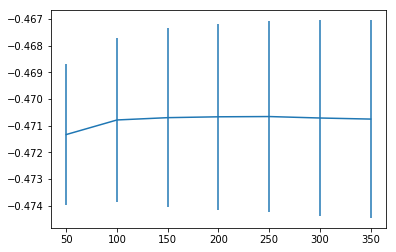

In [21]:
plt.errorbar(n_estimators,means,yerr=stds)

In [22]:
# searching for the best tree depth
max_depth = [2,4,6,8,10]
param_grid  =dict(max_depth = max_depth)
KFold = StratifiedKFold(n_splits =10,shuffle =True,random_state=7)
grid_search = GridSearchCV(model,param_grid,cv =KFold,scoring ='neg_log_loss',n_jobs=-1)
results = grid_search.fit(XTrain,YTrain)
print (results.best_score_,results.best_params_)

-0.470343279361 {'max_depth': 4}


In [26]:
results.best_params_['max_depth']

4

<Container object of 3 artists>

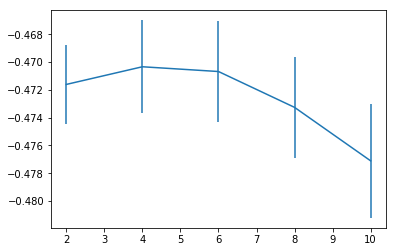

In [30]:
means = results.cv_results_['mean_test_score']
stds = results.cv_results_['std_test_score']
params = results.cv_results_['params']

plt.errorbar(max_depth,means,yerr=stds)

In [31]:
#optimizing both depth and number of trees
max_depth =[1,2,3,4,5,6,7,8]
n_estimators = [50,100,150,200,250,300,350,400]
param_grid = dict(max_depth= max_depth,n_estimators = n_estimators)
kFold = StratifiedKFold(n_splits=10,random_state=7,shuffle=True)
grid_search = GridSearchCV(model,param_grid,scoring="neg_log_loss",n_jobs=-1,cv=kFold)
results = grid_search.fit(XTrain,YTrain)

In [32]:
print (results.best_score_,results.best_params_)

-0.47025611265 {'max_depth': 6, 'n_estimators': 50}


In [34]:
model = XGBClassifier(max_depth=6,n_estimators=50)
model.fit(XTrain,YTrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:

print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [35]:
predcited = model.predict(XTest)
predctions  =[round(value) for value in predcited]
accuracy = (accuracy_score(YTest,predctions))
print("Accuracy : %.2f%%"%(accuracy*100))

Accuracy : 78.96%


In [36]:

confusion_matrix(YTest,predctions)

array([[11040,    22],
       [ 2923,    15]], dtype=int64)

In [46]:
pd.crosstab(YTest,predctions,rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,11040,22,11062
1,2923,15,2938
All,13963,37,14000


In [48]:
sensititvity = 11040/(11040+22)
print(sensititvity)

0.9980112095461942


In [49]:
specificity = 15/(2923+15)
print(specificity)

0.0051055139550714775


In [51]:
positve_likelihood_Ratio =sensititvity/(1-specificity)
print(positve_likelihood_Ratio)

1.0031327176348679


In [52]:
Negative_likelihood_Ratio =1-sensititvity/(specificity)
print(Negative_likelihood_Ratio)

-194.47712890978121


In [53]:
#if the model predicts that customer will come, it is 79% certain that patient will comme
PPV = 11040/(2923+11040)
print(PPV)

0.7906610327293562


In [55]:
# if the model says customer will not come/it is 41% certain that patient will not comme(not enough)
NPV = 15/(15+22)
print(NPV)

0.40540540540540543


In [58]:
clf =  MultinomialNB().fit(XTrain, YTrain)
print('Accuracy:', round(accuracy_score(YTest, 
                                        clf.predict(XTest)), 2) * 100, '%')

Accuracy: 78.0 %


In [59]:
pd.crosstab(YTest,clf.predict(XTest),rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,10759,303,11062
1,2759,179,2938
All,13518,482,14000


In [ ]:
# 10759 , 327 , 2759 , 200

In [60]:
#if the model predicts that customer will come, it is 80% certain that patient will comme
PPV = 10759/(2759+10759)
print(PPV)

0.7959017606154757


In [62]:
# if the model says customer will not come/it is 37% certain that patient will not comme(now we can think about it)
NPV = 200/(327+200)
print(NPV)

0.3795066413662239


In [64]:
clf

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [66]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [71]:
alpha = [1,.1,.01,.001]
grid_param = dict(alpha = alpha)
KFold = StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
grid_search = GridSearchCV(clf,grid_param,scoring="neg_log_loss",n_jobs=-1,cv=kFold)
results = grid_search.fit(XTrain,YTrain)

In [72]:
print(results.best_score_ , results.best_params_)

-0.487298683868 {'alpha': 1}


In [77]:
clf =  MultinomialNB(alpha=.01).fit(XTrain, YTrain)
print('Accuracy:', round(accuracy_score(YTest, 
                                        clf.predict(XTest)), 2) * 100, '%')

Accuracy: 78.0 %


In [78]:
pd.crosstab(YTest,clf.predict(XTest),rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,10759,303,11062
1,2760,178,2938
All,13519,481,14000


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [21]:
KModel = KNeighborsClassifier()
n_neighbors = [pow(2,x) for x in range(0,8)]
param_grid =dict(n_neighbors=n_neighbors)
kCv = StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
modelGridSearch = GridSearchCV(KModel,param_grid,scoring="neg_log_loss",cv=kCv,n_jobs=-1)
modelGridSearch.fit(XTrain,YTrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 4, 8, 16, 32, 64, 128]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [22]:
KModel = modelGridSearch
prediction = KModel.predict(XTest)
pd.crosstab(YTest,prediction,rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,All
Actual,,
0,11062,11062
1,2938,2938
All,14000,14000


In [23]:
from sklearn.metrics import classification_report
print(classification_report(YTest,prediction))

             precision    recall  f1-score   support

          0       0.79      1.00      0.88     11062
          1       0.00      0.00      0.00      2938

avg / total       0.62      0.79      0.70     14000



C:\Users\anurag dubey\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
#stacking 
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.svm import SVC



In [26]:
class skLearnerHelper(object):
    def __init__(self,clf,seed=0,params=None):
        params["random_state"] = seed
        self.clf = clf(**params)
    def train(self, Xtrain,Ytrain):
        self.clf.fit(Xtrain,Ytrain)
    def fit(self,X,Y):
        return self.clf.fit(X,Y)
    def predict(self,Xtest):
        return self.clf.predict(Xtest)
    def featureImportances(self,X,Y):
        return self.clf.fit(X,Y).feature_importances_

In [1]:
kFold = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

NameError: name 'train' is not defined

In [27]:
data =pd.read_csv("D:/CBA/FA/data.csv")

In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

In [29]:
data.dtypes

Month                object
Ridership ('000)      int64
ln(ridership)       float64
t                     int64
t2                    int64
dtype: object

In [19]:
#let's check for class imbalance
Y_New.value_counts()
Y_Trans = labelEncoder.fit_transform(Y_New)
XTrain,XTest,YTrain,YTest = train_test_split(TrainS,Y_Trans,test_size = 0.2,random_state = 7)


In [25]:
sm = SMOTE(random_state=7,ratio=1)
XTrain_smo, YTrain_smo = sm.fit_sample(XTrain,YTrain)

C:\Users\anurag dubey\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [26]:
YTrain_smo.

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [27]:
model = XGBClassifier()
model.fit(XTrain,YTrain)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [39]:
predcited =model.predict(XTest)
predctions  =[round(value) for value in predcited]
accuracy = (accuracy_score(YTest,predctions))
print(accuracy)
from sklearn.metrics import confusion_matrix
Tp,FN,FP,TN =confusion_matrix(YTest,predctions).ravel()
print (confusion_matrix(YTest,predctions))
print (Tp,FN,FP,TN )
from sklearn.metrics import classification_report
print(classification_report(YTest,predctions))

0.790142857143
[[11054     8]
 [ 2930     8]]
11054 8 2930 8
             precision    recall  f1-score   support

          0       0.79      1.00      0.88     11062
          1       0.50      0.00      0.01      2938

avg / total       0.73      0.79      0.70     14000



In [37]:
YTest

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [32]:

predcited = model.predict(XTest)
predctions  =[round(value) for value in predcited]
accuracy = (accuracy_score(YTest,predctions))
print("Accuracy : %.2f%%"%(accuracy*100))
from sklearn.metrics import confusion_matrix
Tp,FN,FP,TN =confusion_matrix(YTest,predctions).ravel()
print (confusion_matrix(YTest,predctions))
print (Tp,FN,FP,TN )

Accuracy : 79.01%
[[11054     8]
 [ 2930     8]]
11054 8 2930 8


In [26]:
#performing parameter tuning for randome forest

print (rfmodel.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [40]:
n_estimators = [500,700,1000]

max_depth = [5,7,9]
para_dict  =dict(n_estimators=n_estimators,max_depth=max_depth)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import  GridSearchCV
kfold = StratifiedKFold(n_splits=10,random_state=7, shuffle = True)
gridSearch  =  GridSearchCV(rfmodel,para_dict,scoring ="neg_log_loss",n_jobs=-1,cv =kfold)
results = gridSearch.fit(XTrain,YTrain)

In [42]:
print (results.best_score_,results.best_params_)

-0.47134059144 {'max_depth': 9, 'n_estimators': 700}


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
rfmodel = RandomForestClassifier(max_depth=9,n_estimators=700)
rfmodel.fit(XTrain,YTrain)

predcited = rfmodel.predict(XTest)
predctions  =[round(value) for value in predcited]
accuracy = (accuracy_score(YTest,predctions))
print("Accuracy : %.2f%%"%(accuracy*100))   
from sklearn.metrics import confusion_matrix
Tp,FN,FP,TN =confusion_matrix(YTest,predctions).ravel()
print (confusion_matrix(YTest,predctions))
print (Tp,FN,FP,TN )
from sklearn.metrics import classification_report
print(classification_report(YTest,predctions))

Accuracy : 79.04%


In [45]:
from sklearn.metrics import confusion_matrix
Tp,FN,FP,TN =confusion_matrix(YTest,predctions).ravel()
print (confusion_matrix(YTest,predctions))
print (Tp,FN,FP,TN )
from sklearn.metrics import classification_report
print(classification_report(YTest,predctions))


[[11059     3]
 [ 2932     6]]
11059 3 2932 6
             precision    recall  f1-score   support

          0       0.79      1.00      0.88     11062
          1       0.67      0.00      0.00      2938

avg / total       0.76      0.79      0.70     14000



In [ ]:
from sklearn import  svm
svcc = svm.SVC(kernel="poly",C=100,gamma=10)
svcc.fit(XTrain,YTrain)

predcited = svcc.predict(XTest)
predctions  =[round(value) for value in predcited]
accuracy = (accuracy_score(YTest,predctions))
print("Accuracy : %.2f%%"%(accuracy*100))   
from sklearn.metrics import confusion_matrix
Tp,FN,FP,TN =confusion_matrix(YTest,predctions).ravel()
print (confusion_matrix(YTest,predctions))
print (Tp,FN,FP,TN )
from sklearn.metrics import classification_report
print(classification_report(YTest,predctions))